In [1]:
!pip install swin-transformer-pytorch


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 10.8 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.8.93
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.9.90
    Uninstalling nvidia-curand-cu12-1

In [2]:
# randomaug.py Code

# code in this file is adpated from rpmcruz/autoaugment
# https://github.com/rpmcruz/autoaugment/blob/master/transformations.py
import random
import PIL, PIL.ImageOps, PIL.ImageEnhance, PIL.ImageDraw
import numpy as np
import torch
from PIL import Image

def ShearX(img, v): # [-0.3, 0.3]
    assert -0.3 <= v <= 0.3
    if random.random() > 0.5:
      v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, v, 0, 0, 1, 0))

def ShearY(img, v): # [-0.3, 0.3]
    assert -0.3 <= v <= 0.3
    if random.random() > 0.5:
      v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, v, 1, 0))

def TranslateX(img, v): # [-150, 150] => percentage: [-0.45, 0.45]
    assert -0.45 <= v <= 0.45
    if random.random() > 0.5:
      v = -v
    v = v * img.size[0]
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, v, 0, 1, 0))

def TranslateXabs(img, v): # [-150, 150] => percentage: [-0.45, 0.45]
    assert 0 <= v
    if random.random() > 0.5:
      v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, v, 0, 1, 0))

def TranslateY(img, v): # [-150, 150] => percentage: [-0.45, 0.45]
    assert -0.45 <= v <= 0.45
    if random.random() > 0.5:
      v = -v
    v = v * img.size[1]
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, 0, 1, v))

def TranslateYabs(img, v): # [-150, 150] => percentage: [-0.45, 0.45]
    assert 0 <= v
    if random.random() > 0.5:
      v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, 0, 1, v))

def Rotate(img, v): # [-30, 30]
    assert -30 <= v <= 30
    if random.random() > 0.5:
      v = -v
    return img.rotate(v)

def AutoContrast(img, _):
    return PIL.ImageOps.autocontrast(img)

def Invert(img, _):
    return PIL.ImageOps.invert(img)

def Equalize(img, _):
    return PIL.ImageOps.equalize(img)

def Flip(img, _): # not from the paper
    return PIL.ImageOps.mirror(img)

def Solarize(img, v): # [0, 256]
    assert 0 <= v <= 256
    return PIL.ImageOps.solarize(img, v)

def SolarizeAdd(img, addition=0, threshold=128):
    img_np = np.array(img).astype(int)
    img_np = img_np + addition
    img_np = np.clip(img_np, 0, 255)
    img_np = img_np.astype(np.uint8)
    img = Image.fromarray(img_np)
    return PIL.ImageOps.solarize(img, threshold)

def Posterize(img, v): # [4, 8]
    v = int(v)
    v = max(1, v)
    return PIL.ImageOps.posterize(img, v)

def Contrast(img, v): # [0.1,1.9]
    assert 0.1 <= v <= 1.9
    return PIL.ImageEnhance.Contrast(img).enhance(v)

def Color(img, v): # [0.1,1.9]
    assert 0.1 <= v <= 1.9
    return PIL.ImageEnhance.Color(img).enhance(v)

def Brightness(img, v): # [0.1,1.9]
    assert 0.1 <= v <= 1.9
    return PIL.ImageEnhance.Brightness(img).enhance(v)

def Sharpness(img, v): # [0.1,1.9]
    assert 0.1 <= v <= 1.9
    return PIL.ImageEnhance.Sharpness(img).enhance(v)

def Cutout(img, v): # [0, 60] => percentage: [0, 0.2]
    assert 0.0 <= v <= 0.2
    if v <= 0.:
      return img
    v = v * img.size[0]
    return CutoutAbs(img, v)


def CutoutAbs(img, v): # [0, 60] => percentage: [0, 0.2]
    # assert 0 <= v <= 20
    if v < 0:
        return img
    w, h = img.size
    x0 = np.random.uniform(w)
    y0 = np.random.uniform(h)
    x0 = int(max(0, x0 - v / 2.))
    y0 = int(max(0, y0 - v / 2.))
    x1 = min(w, x0 + v)
    y1 = min(h, y0 + v)
    xy = (x0, y0, x1, y1)
    color = (125, 123, 114)
    # color = (0, 0, 0)
    img = img.copy()
    PIL.ImageDraw.Draw(img).rectangle(xy, color)
    return img


def SamplePairing(imgs): # [0, 0.4]
    def f(img1, v):
        i = np.random.choice(len(imgs))
        img2 = PIL.Image.fromarray(imgs[i])
        return PIL.Image.blend(img1, img2, v)
    return f

def Identity(img, v):
    return img

def augment_list(): # 16 oeprations and their ranges
    l = [
    (AutoContrast, 0, 1),
    (Equalize, 0, 1),
    (Invert, 0, 1),
    (Rotate, 0, 30),
    (Posterize, 0, 4),
    (Solarize, 0, 256),
    (SolarizeAdd, 0, 110),
    (Color, 0.1, 1.9),
    (Contrast, 0.1, 1.9),
    (Brightness, 0.1, 1.9),
    (Sharpness, 0.1, 1.9),
    (ShearX, 0., 0.3),
    (ShearY, 0., 0.3),
    (CutoutAbs, 0, 40),
    (TranslateXabs, 0., 100),
    (TranslateYabs, 0., 100),
    ]
    return l


class Lighting(object):
    """Lighting noise(AlexNet - style PCA - based noise)"""
    def __init__(self, alphastd, eigval, eigvec):
        self.alphastd = alphastd
        self.eigval = torch.Tensor(eigval)
        self.eigvec = torch.Tensor(eigvec)

    def __call__(self, img):
        if self.alphastd == 0:
            return img
        alpha = img.new().resize_(3).normal_(0, self.alphastd)
        rgb = self.eigvec.type_as(img).clone().mul(alpha.view(1, 3).expand(3, 3)).mul(self.eigval.view(1, 3).expand(3, 3)).sum(1).squeeze()
        return img.add(rgb.view(3, 1, 1).expand_as(img))



class CutoutDefault(object):
    """
    Reference: https://github.com/quark0/darts/blob/master/cnn/utils.py
    """
    def __init__(self, length):
        self.length = length

    def __call__(self, img):
        h, w = img.size(1), img.size(2)
        mask = np.ones((h, w), np.float32)
        y = np.random.randint(h)
        x = np.random.randint(w)
        y1 = np.clip(y - self.length // 2, 0, h)
        y2 = np.clip(y + self.length // 2, 0, h)
        x1 = np.clip(x - self.length // 2, 0, w)
        x2 = np.clip(x + self.length // 2, 0, w)
        mask[y1: y2, x1: x2] = 0.
        mask = torch.from_numpy(mask)
        mask = mask.expand_as(img)
        img *= mask
        return img



class RandAugment:
    def __init__(self, n, m):
        self.n = n
        self.m = m # [0, 30]
        self.augment_list = augment_list()

    def __call__(self, img):
        ops = random.choices(self.augment_list, k=self.n)
        for op, minval, maxval in ops:
            val = (float(self.m) / 30) * float(maxval - minval) + minval
            img = op(img, val)
        return img


In [3]:
# Utils.py Code

import torch
import torchvision
import torchvision.transforms as transforms


def get_loaders_CIFAR10(size, batch_size, aug=True,N = 2, M = 14):
    transform_train = transforms.Compose([transforms.RandomCrop(32, padding=4),
                                          transforms.Resize(size),
                                          transforms.RandomHorizontalFlip(),
                                          transforms.ToTensor(),
                                          transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
                                          ])

    transform_test = transforms.Compose([transforms.Resize(size),
                                         transforms.ToTensor(),
                                         transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
                                         ])
    # Add RandAugment with N, M(hyperparameter)
    if aug:
        N = 2; M = 14;
        transform_train.transforms.insert(0, RandAugment(N, M))
    # Prepare dataset
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              shuffle=True, num_workers=8)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False,
                                             num_workers=8)
    return trainloader, testloader


def get_loaders_CIFAR100(size, batch_size, aug=True,N = 2, M = 14):
    transform_train = transforms.Compose([transforms.RandomCrop(32, padding=4),
                                          transforms.Resize(size),
                                          transforms.RandomHorizontalFlip(),
                                          transforms.ToTensor(),
                                          transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
                                          ])
    transform_test = transforms.Compose([transforms.Resize(size),
                                         transforms.ToTensor(),
                                         transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
                                         ])
    # Add RandAugment with N, M(hyperparameter)
    if aug:
        N = 2; M = 14;
        transform_train.transforms.insert(0, RandAugment(N, M))
    # Prepare dataset
    trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                             download=True, transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              shuffle=True, num_workers=8)
    testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                            download=True, transform=transform_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False,
                                             num_workers=8)
    return trainloader, testloader



In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import numpy as np
import sys
import matplotlib.pyplot as plt
import warnings

import torchvision
import torchvision.transforms as transforms

import os
import argparse
import pandas as pd
import csv
import time
from swin_transformer_pytorch import swin_t

warnings.filterwarnings('ignore')


device = 'cuda' if torch.cuda.is_available() else 'cpu' # parsers
parser = argparse.ArgumentParser(description='PyTorch CIFAR10 Training')
parser.add_argument('--dataset', default='CIFAR10') # options: CIFAR10, CIFAR100
parser.add_argument('--dataset_classes', default='10') # options: 10 for CIFAR10, 100 fr CIFAR100
parser.add_argument('--lr', default=1e-4, type=float, help='learning rate') #
parser.add_argument('--opt', default="adam")
parser.add_argument('--resume', '-r', action='store_true', help='resume from checkpoint')
parser.add_argument('--noaug', action='store_false', help='disable use randomaug')
parser.add_argument('--noamp', action='store_true', help='disable mixed precision training. for older pytorch versions')
parser.add_argument('--net', default='swin') # options: vit, swin, cait, twins
parser.add_argument('--heads', default='6')
parser.add_argument('--layers', default='12')    # depth
parser.add_argument('--dp', action='store_true', help='use data parallel')
parser.add_argument('--bs', default='64')    # was 512
parser.add_argument('--size', default="32")
parser.add_argument('--n_epochs', type=int, default='200')
parser.add_argument('--patch', default='4', type=int, help="patch for ViT")
parser.add_argument('--dimhead', default="420", type=int) # or 512

args, unknown = parser.parse_known_args()
best_acc = 0

# Store epoch and accuracy for visualization
epoch_acc_data = []
train_acc_data = []
train_loss_data = []
test_loss_data = []

def count_parameters(model): # count number of trainable parameters in the model
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def main():
    global epoch_acc_data, train_acc_data, train_loss_data, test_loss_data
    bs = int(args.bs)
    imsize = int(args.size)

    use_amp = not args.noamp
    aug = args.noaug

    best_acc = 0    # best test accuracy
    start_epoch = 0    # start from epoch 0 or last checkpoint epoch

    # Data
    print('==> Preparing data..')
    size = imsize
    trainloader, testloader = get_loaders_CIFAR10(size, bs)

    classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    # Model factory..
    net = swin_t(window_size=args.patch,
                 num_classes=int(args.dataset_classes), downscaling_factors=(2,2,2,1))
    pcount = count_parameters(net)
    print("count of parameters in the model = ", pcount/1e6, " million")

    if args.resume:
        # Load checkpoint.
        print('==> Resuming from checkpoint..')
        assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
        checkpoint = torch.load('./checkpoint/{}-ckpt.t7'.format(args.net))
        net.load_state_dict(checkpoint['model'])
        best_acc = checkpoint['acc']
        start_epoch = checkpoint['epoch']

    # Loss is CE
    criterion = nn.CrossEntropyLoss()

    if args.opt == "adam":
        optimizer = optim.Adam(net.parameters(), lr=args.lr)
    elif args.opt == "sgd":
        optimizer = optim.SGD(net.parameters(), lr=args.lr)

    # use cosine scheduling
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, args.n_epochs)

    ##### Training
    scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
    list_loss = []
    list_acc = []


    net.cuda()

    print("\nEpoch | Train Acc (%) | Test Acc (%) | Train Loss | Test Loss")
    print("--------------------------------------------------------------")
    
    for epoch in range(start_epoch, args.n_epochs):
        start = time.time()
        train_loss, train_acc = train(epoch, net, trainloader, criterion,scaler,optimizer, use_amp)


        val_loss, acc = test(epoch, net, testloader, criterion, optimizer, scaler)
        scheduler.step(epoch-1) # step cosine scheduling list_loss.append(val_loss)
        list_acc.append(acc)

        # Save epoch and accuracy for later use
        train_loss_data.append(train_loss)
        test_loss_data.append(val_loss)
        train_acc_data.append((epoch, train_acc))
        epoch_acc_data.append((epoch, acc))

        print(f"{epoch+1:5d} | {train_acc:13.2f} | {acc:12.2f} | {train_loss:10.4f} | {val_loss:9.4f}")


def train(epoch, net, trainloader, criterion, scaler, optimizer, use_amp):
    
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device) # Train with amp
        with torch.cuda.amp.autocast(enabled=use_amp):
            outputs = net(inputs)
            loss = criterion(outputs, targets)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    return train_loss/(batch_idx+1), 100. * correct / total

##### Validation

def test(epoch, net, testloader, criterion, optimizer, scaler):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()


    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        state = {"model": net.state_dict(), 
                 "optimizer": optimizer.state_dict(), 
                 "acc": acc, "epoch": epoch, 
                 "scaler": scaler.state_dict()} 
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/'+args.net+'-{}-ckpt.t7'.format(args.patch)) 
        best_acc = acc
    return test_loss/(batch_idx+1), acc


if  __name__ == "__main__":
    main()

==> Preparing data..


100%|██████████| 170M/170M [00:15<00:00, 11.2MB/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
count of parameters in the model =  26.598646  million

Epoch | Train Acc (%) | Test Acc (%) | Train Loss | Test Loss
--------------------------------------------------------------
    1 |         14.09 |        26.04 |     2.2640 |    1.8654
    2 |         21.23 |        35.04 |     2.0701 |    1.7097
    3 |         25.29 |        34.30 |     1.9767 |    1.8138
    4 |         27.81 |        39.99 |     1.9156 |    1.5930
    5 |         30.40 |        46.80 |     1.8606 |    1.4538
    6 |         32.45 |        50.10 |     1.8077 |    1.3574
    7 |         33.73 |        52.89 |     1.7811 |    1.2866
    8 |         35.71 |        54.99 |     1.7313 |    1.2337
    9 |         36.65 |        52.93 |     1.7082 |    1.2625
   10 |         37.86 |        57.64 |     1.6778 |    1.1694
   11 |         39.47 |        55.99 |     1.6427 |    1.1935
   12 |         40.25 |        60.62 |     1.621

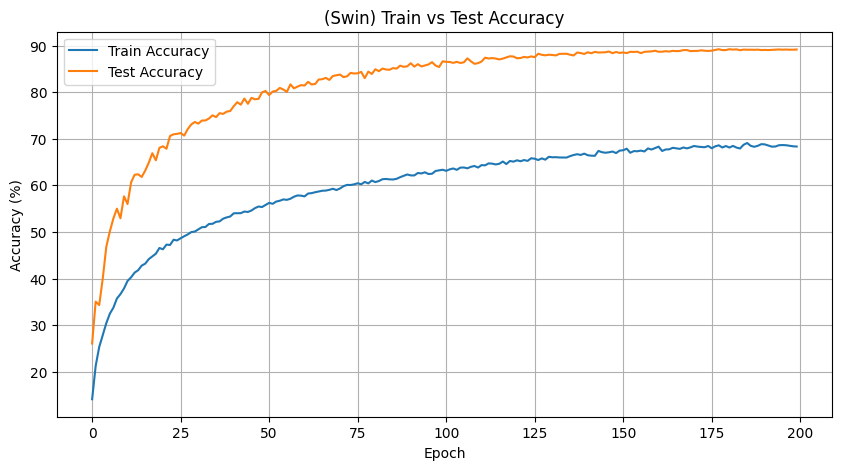

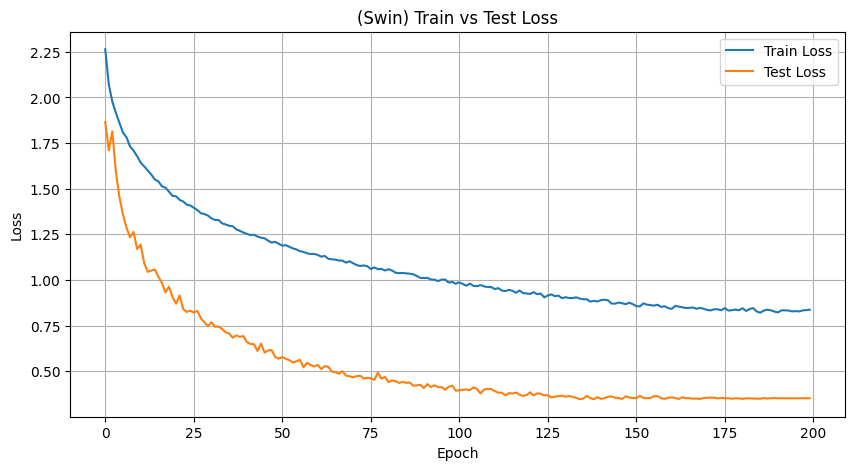

In [6]:
def plot_metrics():
    epochs = [e for e, _ in epoch_acc_data]
    train_accuracies = [acc for _, acc in train_acc_data]
    test_accuracies = [acc for _, acc in epoch_acc_data]
    # Accuracy comparison
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, test_accuracies, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('(Swin) Train vs Test Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()
    # Loss comparison
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_loss_data, label='Train Loss')
    plt.plot(epochs, test_loss_data, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('(Swin) Train vs Test Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_metrics()

In [7]:
!pip install vit-pytorch


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.8/140.8 kB 4.5 MB/s eta 0:00:00


==> Preparing data for ViT..
Files already downloaded and verified
Files already downloaded and verified
ViT parameter count =  22.135402  million

Epoch | Train Acc (%) | Test Acc (%) | Train Loss | Test Loss
--------------------------------------------------------------
    1 |         20.38 |        42.92 |     2.1271 |    1.5654
    2 |         27.40 |        47.30 |     1.9532 |    1.4411
    3 |         30.91 |        49.31 |     1.8698 |    1.3637
    4 |         32.18 |        53.45 |     1.8280 |    1.2691
    5 |         34.23 |        55.06 |     1.7840 |    1.2379
    6 |         35.41 |        57.26 |     1.7513 |    1.1748
    7 |         36.47 |        57.43 |     1.7187 |    1.1645
    8 |         37.27 |        59.49 |     1.6938 |    1.1449
    9 |         38.16 |        60.35 |     1.6784 |    1.0897
   10 |         39.07 |        60.01 |     1.6507 |    1.1005
   11 |         39.54 |        63.71 |     1.6433 |    1.0196
   12 |         40.37 |        63.17 |     1.

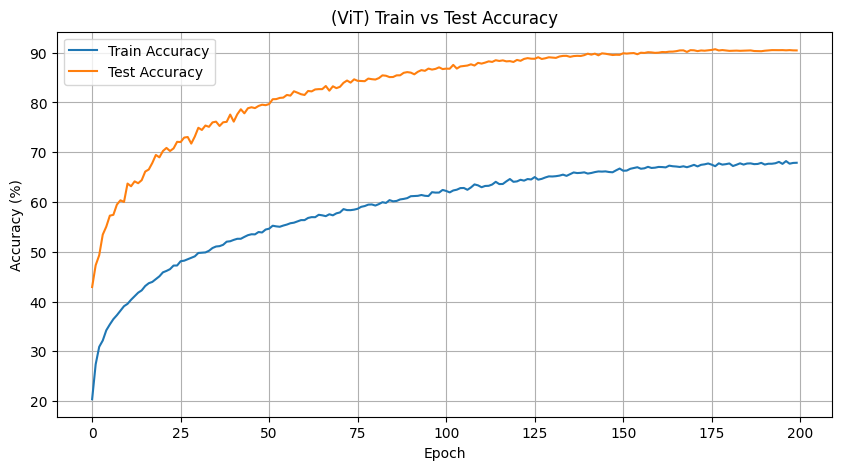

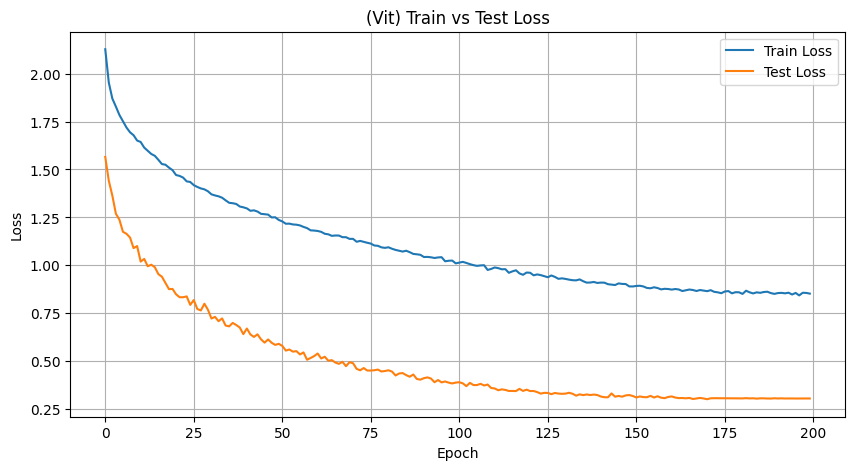

In [8]:
from vit_pytorch import ViT

# Reset metric lists for ViT
vit_epoch_acc_data = []
vit_train_acc_data = []
vit_train_loss_data = []
vit_test_loss_data = []

def main_vit():
    global vit_epoch_acc_data, vit_train_acc_data, vit_train_loss_data, vit_test_loss_data
    bs = int(args.bs)
    imsize = int(args.size)

    use_amp = not args.noamp
    aug = args.noaug

    best_acc = 0
    start_epoch = 0

    print('==> Preparing data for ViT..')
    trainloader, testloader = get_loaders_CIFAR10(imsize, bs, aug)

    # Define ViT model
    net = ViT(
        image_size=imsize,
        patch_size=args.patch,
        num_classes=int(args.dataset_classes),
        dim=512,
        depth=int(args.layers),
        heads=int(args.heads),
        mlp_dim=1024,
        dropout=0.1,
        emb_dropout=0.1
    )

    print("ViT parameter count = ", count_parameters(net) / 1e6, " million")

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=args.lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, args.n_epochs)
    scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

    net.to(device)

    print("\nEpoch | Train Acc (%) | Test Acc (%) | Train Loss | Test Loss")
    print("--------------------------------------------------------------")

    for epoch in range(start_epoch, args.n_epochs):
        train_loss, train_acc = train(epoch, net, trainloader, criterion, scaler, optimizer, use_amp)
        val_loss, acc = test(epoch, net, testloader, criterion, optimizer, scaler)
        scheduler.step(epoch-1)

        vit_train_loss_data.append(train_loss)
        vit_test_loss_data.append(val_loss)
        vit_train_acc_data.append((epoch, train_acc))
        vit_epoch_acc_data.append((epoch, acc))

        print(f"{epoch+1:5d} | {train_acc:13.2f} | {acc:12.2f} | {train_loss:10.4f} | {val_loss:9.4f}")

# Run ViT training
main_vit()

# Plot ViT Accuracy and Loss
def plot_vit_metrics():
    epochs = [e for e, _ in vit_epoch_acc_data]
    train_accuracies = [acc for _, acc in vit_train_acc_data]
    test_accuracies = [acc for _, acc in vit_epoch_acc_data]

    # Accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, test_accuracies, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('(ViT) Train vs Test Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Loss
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, vit_train_loss_data, label='Train Loss')
    plt.plot(epochs, vit_test_loss_data, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('(Vit) Train vs Test Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Show ViT-only graphs
plot_vit_metrics()


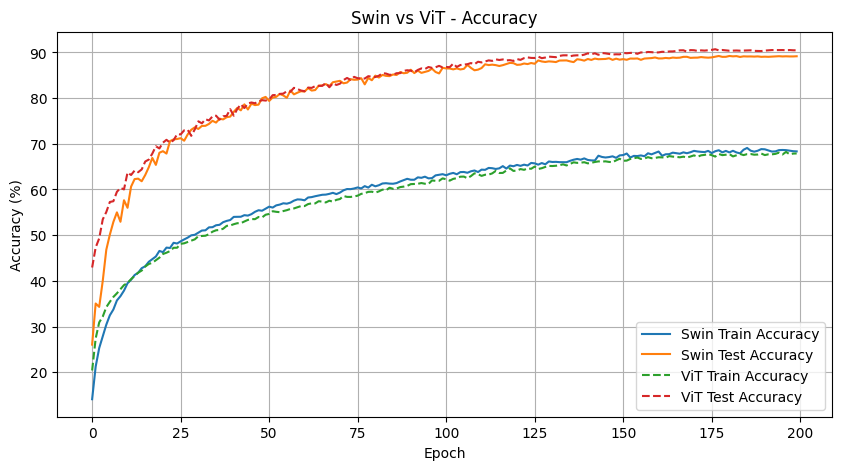

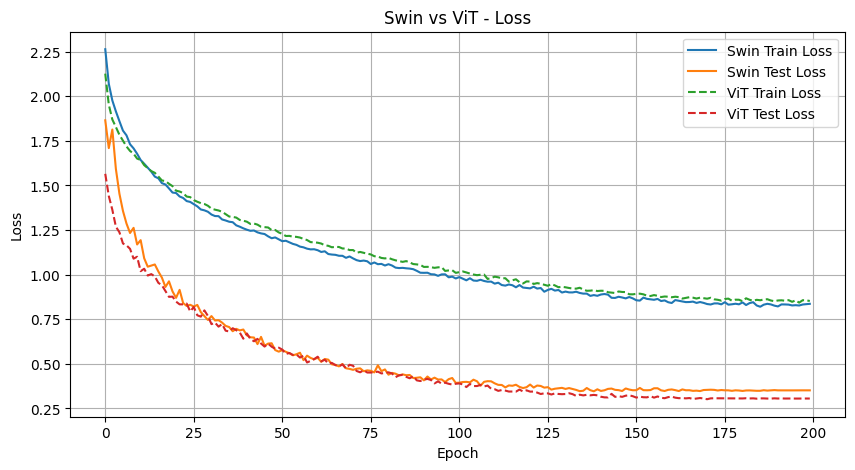

In [9]:
def plot_comparison_swin_vit():
    swin_epochs = [e for e, _ in epoch_acc_data]
    swin_train_acc = [acc for _, acc in train_acc_data]
    swin_test_acc = [acc for _, acc in epoch_acc_data]

    vit_epochs = [e for e, _ in vit_epoch_acc_data]
    vit_train_acc = [acc for _, acc in vit_train_acc_data]
    vit_test_acc = [acc for _, acc in vit_epoch_acc_data]

    # Accuracy Comparison
    plt.figure(figsize=(10, 5))
    plt.plot(swin_epochs, swin_train_acc, label='Swin Train Accuracy')
    plt.plot(swin_epochs, swin_test_acc, label='Swin Test Accuracy')
    plt.plot(vit_epochs, vit_train_acc, '--', label='ViT Train Accuracy')
    plt.plot(vit_epochs, vit_test_acc, '--', label='ViT Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Swin vs ViT - Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Loss Comparison
    plt.figure(figsize=(10, 5))
    plt.plot(swin_epochs, train_loss_data, label='Swin Train Loss')
    plt.plot(swin_epochs, test_loss_data, label='Swin Test Loss')
    plt.plot(vit_epochs, vit_train_loss_data, '--', label='ViT Train Loss')
    plt.plot(vit_epochs, vit_test_loss_data, '--', label='ViT Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Swin vs ViT - Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the comparison function
plot_comparison_swin_vit()
